# MISO voyage - I09S hydrographic section

<div style="float: right; margin-right: 20px; margin-left: 30px; width: 40%; max-width: 250px;">
    <img src="images/miso_path.jpg" width="100%"/>
</div> 

The MISO voyage on CSIRO research vessel RV Investigator sailed from Hobart on 5 January 2024.

MISO stands for: **M**ultidisciplinary **I**nvestigations of the **S**outhern **O**cean.

The aim of the 60-day voyage was to improve our ability to anticipate the impacts of future climate change. This voyage contributed to the GO-SHIP program's long term monitoring effort, which carries out repeated hydrographic transects (or cross sections) at key locations.

These surveys are typically carried out once a decade (at least) since the 1970s, in every ocean basin. ideally from coast to coast, and allow to monitor changes in the inventories of heat, freshwater, carbon, oxygen, nutrients, etc. This is an international effort: you can see a list of the countries involved [here](https://www.go-ship.org/RefSecs/goship_ref_secs.html).

Now you are going to work with the I09S cross section that runs from the Antarctic continent to Fremantle at around 120E. This line has been "occupied" four times during the years 1995, 2004/05, 2012 and the latest one during 2024 as part of the (MISO) voyage.

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean as cm
import glob
import matplotlib.pyplot as plt
import metpy
import numpy as np
import xarray as xr

## Building a cross section from CTD profiles

First, open the CTD files by getting a (sorted) list of the paths, iterating and saving onto a dictionary. They keys to access the dictionary are numbers. Since we are at it, let's extract the locations (latitude, longitude) from the profiles as well.

In [3]:
path_to_files = glob.glob('data/i09s_ctds/*Ctd*') 
path_to_files = np.sort(path_to_files)
path_to_files

array(['data/i09s_ctds\\in2024_v01034CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01035CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01036CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01037CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01038CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01039CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01040CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01044CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01045CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01046CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01047CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01048CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01049CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01050CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01051CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01052CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01053CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01054CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01055CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01056CtdAvg.nc',
       'data/i09s_ct

In [4]:
CTDs = {}; lat = []; lon = []
for i in range(0, len(path_to_files)):
    CTDs[i] = xr.open_dataset(path_to_files[i])
    lat.append(CTDs[i]['latitude'].item())
    lon.append(CTDs[i]['longitude'].item())

Let's do a quick plot of the locations:

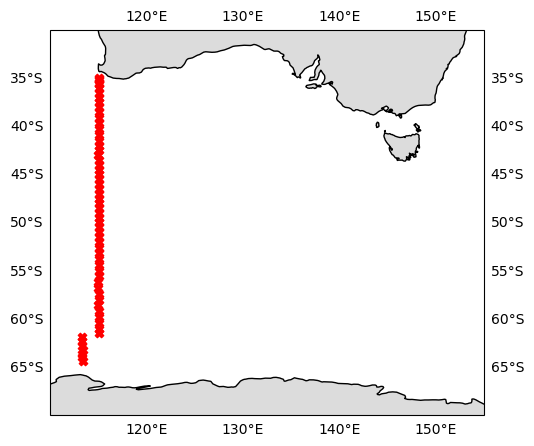

In [5]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(projection = ccrs.PlateCarree(central_longitude = 130))
ax.set_extent([110, 155, -70, -30], crs = ccrs.PlateCarree())
ax.add_feature(cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gainsboro'))
gl = ax.gridlines(draw_labels = True, linewidth = 0)
gl.xformatter = ccrs.cartopy.mpl.ticker.LongitudeFormatter()
gl.yformatter = ccrs.cartopy.mpl.ticker.LatitudeFormatter()
ax.scatter(lon, lat, marker = 'X', color = 'red', transform = ccrs.PlateCarree());

Each of the red crosses is a CTD profile. We want to use these to create a cross-section, which has dimensions of depth or pressure in the vertical, and latitudes in the horizontal. In order to do this we need to interpolate twice:

1. First interpolate each CTD profile to the same pressure levels
2. Second, interpolate spatially to 114.7E (I09S's longitude), and an evenly spaced latitude axis.

To do the first interpolation, we will use `xarray.interp()` function, iterating through each individual profile, with a target pressure between the surface and 6000dbar, spaced by 1dbar. We will choose a linear interpolation, but there are other methods available. Feel free to explore how the results differ by choosing other interpolation methods.

In [6]:
target_pressure = np.arange(1, 6001, 1)
CTDs_interp = {}
for k in list(CTDs.keys()):
    CTDs_interp[k] = CTDs[k].interp(pressure = target_pressure, method = 'linear')

Now that our CTD profiles have been interpolated to the same vertical levels, we can arrange the variables of interest (temperature and salinity) onto 2D arrays, where the horizontal dimension will be for now `CTD_number`

In [7]:
temperature = xr.DataArray(data = np.empty([len(target_pressure), len(path_to_files)]),
                           coords = {'pressure': target_pressure,
                                     'CTD_number': np.arange(0, len(path_to_files), 1)})

salinity = xr.DataArray(data = np.empty([len(target_pressure), len(path_to_files)]),
                        coords = {'pressure': target_pressure,
                                  'CTD_number': np.arange(0, len(path_to_files), 1)})

for i in range(0, len(path_to_files)):
    temperature.loc[{'CTD_number':i}] = CTDs_interp[i]['temperature'].squeeze().values
    salinity.loc[{'CTD_number':i}] = CTDs_interp[i]['salinity'].squeeze().values

Let's do a quick plot so see what it looks like:

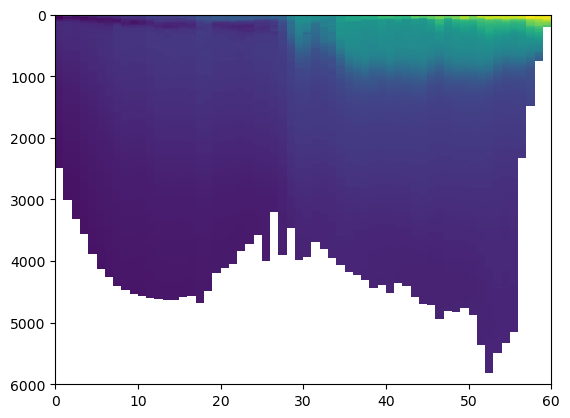

In [8]:
plt.pcolormesh(temperature)
plt.gca().invert_yaxis()

It already resembles a cross section. However, we might be mis-representing horizontal distances because the CTD's are not evenly spaced. So let's do the second interpolation to go from the individual longitude and latitudes to 114.7E and evenly space latitudes (say every 0.25 degrees).

We will do this using `metpy.interpolate.interpolate_to_points`. We need to feed this function three things:
- The original locations of the observations, which we will call `points`
- The values of the observations at these locations, in our case temperature, which we will call `values`
- The target locations of interpolation, the Easy Ocean locations, which we will call `xi`

You can use `help()` to access the documentation.

In [9]:
points = np.stack([lon, lat], axis = 1)
print('The shape of points is :'+str(np.shape(points)))

values = temperature.T.values
print('The shape of values is :'+str(np.shape(values)))

target_latitude = np.arange(-65, -34.75, .25)
xi = np.stack([np.ones(len(target_latitude))*114.7, 
               target_latitude], axis = 1)
print('The shape of xi is :'+str(np.shape(xi)))

The shape of points is :(60, 2)
The shape of values is :(60, 6000)
The shape of xi is :(121, 2)


In [10]:
temperature_interp = metpy.interpolate.interpolate_to_points(points, values, xi, interp_type = 'nearest')
# Create a dataarray
temperature_interp = xr.DataArray(temperature_interp.T, 
                                  coords = {'pressure': target_pressure,
                                            'latitude': target_latitude},
                                  name = 'temperature')

In [11]:
salinity_interp = metpy.interpolate.interpolate_to_points(points, salinity.T.values, xi, interp_type = 'nearest')
# Create a dataarray
salinity_interp = xr.DataArray(salinity_interp.T, 
                                  coords = {'pressure': target_pressure,
                                            'latitude': target_latitude},
                                  name = 'temperature')

Let's plot:

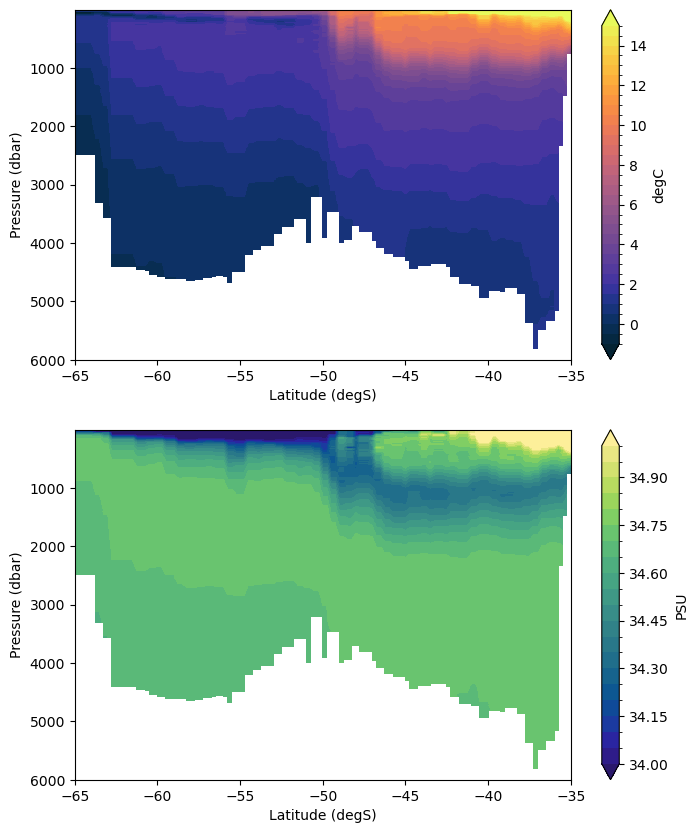

In [12]:
fig, axs = plt.subplots(2, 1, figsize = (8, 10))
temperature_interp.plot.contourf(ax = axs[0], vmin = -1, vmax = 15, levels = 33, cmap = cm.cm.thermal,
                                 yincrease = False, cbar_kwargs = {'label':'degC'})
salinity_interp.plot.contourf(ax = axs[1], vmin = 34, vmax = 35, levels = 21, cmap = cm.cm.haline,
                                 yincrease = False, cbar_kwargs = {'label':'PSU'})
for ax in axs:
    ax.set_xlabel('Latitude (degS)')
    ax.set_ylabel('Pressure (dbar)')

## Comparison with ACCESS-OM2

ACCESS-OM2 is Australia's ocean/sea ice model. It is developed and maintained by the COSIMA community and is available in several different configurations, including different horizontal resolutions and applied forcing. The COSIMA community also maintains a repository with python code used to analyse model output, called the [COSIMA recipes](https://github.com/COSIMA/cosima-recipes).

We will compare the I09S cross-section from the MISO voyage to the model's output. The configuration we will use is the highest horizontal resolution (0.1 $^{\circ}$) from an experiment that has been forced with a prescribed atmosphere from a reanalysis product from 1958 to 2018. 

In [18]:
model_temperature = xr.open_dataarray('data/access_temp_i09s.nc')-273.15 # Model's temperature comes in Kelvin
model_salinity = xr.open_dataarray('data/access_salt_i09s.nc')

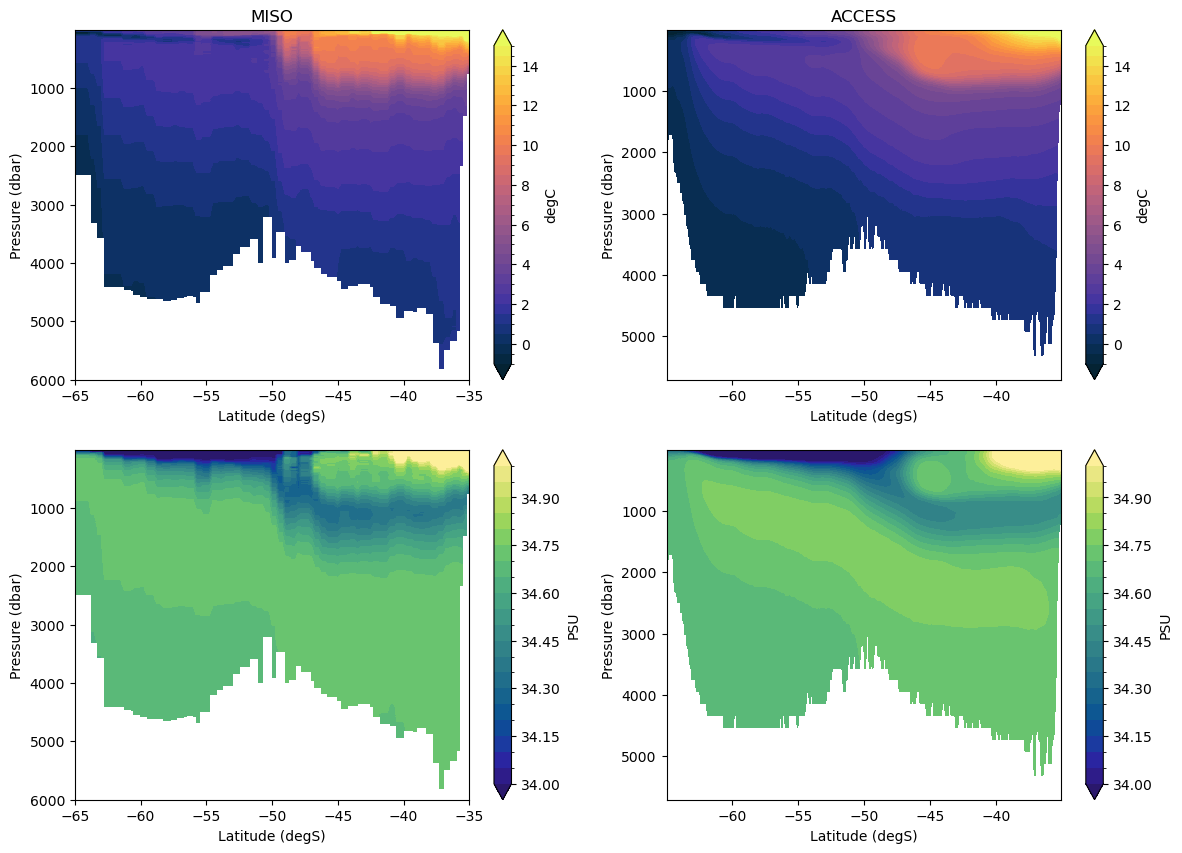

In [24]:
fig, axs = plt.subplots(2, 2, figsize = (14, 10))
temperature_interp.plot.contourf(ax = axs[0,0], vmin = -1, vmax = 15, levels = 33, cmap = cm.cm.thermal,
                                 yincrease = False, cbar_kwargs = {'label':'degC'})
salinity_interp.plot.contourf(ax = axs[1,0], vmin = 34, vmax = 35, levels = 21, cmap = cm.cm.haline,
                                 yincrease = False, cbar_kwargs = {'label':'PSU'})

model_temperature.mean('time').plot.contourf(ax = axs[0,1], vmin = -1, vmax = 15, levels = 33, cmap = cm.cm.thermal,
                                 yincrease = False, cbar_kwargs = {'label':'degC'})
model_salinity.mean('time').plot.contourf(ax = axs[1,1], vmin = 34, vmax = 35, levels = 21, cmap = cm.cm.haline,
                                 yincrease = False, cbar_kwargs = {'label':'PSU'})
for ax in axs.flatten():
    ax.set_xlabel('Latitude (degS)')
    ax.set_ylabel('Pressure (dbar)')
    ax.set_title('')
axs[0,0].set_title('MISO')
axs[0,1].set_title('ACCESS');

Looks pretty similar! Let's see what the biases in the model are (difference with obs).

To do this, we need to rename the dimensions of the model (`st_ocean` -> `pressure` and `yt_ocean` -> `latitude`) and interpolate to the same levels. Technically, we should convert depth to pressure, but the error is quite small so let's just ignore it for the time being.

In [26]:
model_temperature_interp = model_temperature.rename({'st_ocean':'pressure', 'yt_ocean':'latitude'})
model_temperature_interp = model_temperature_interp.interp(pressure = temperature_interp['pressure'], latitude = temperature_interp['latitude'])
model_salinity_interp = model_salinity.rename({'st_ocean':'pressure', 'yt_ocean':'latitude'})
model_salinity_interp = model_salinity_interp.interp(pressure = salinity_interp['pressure'], latitude = salinity_interp['latitude'])

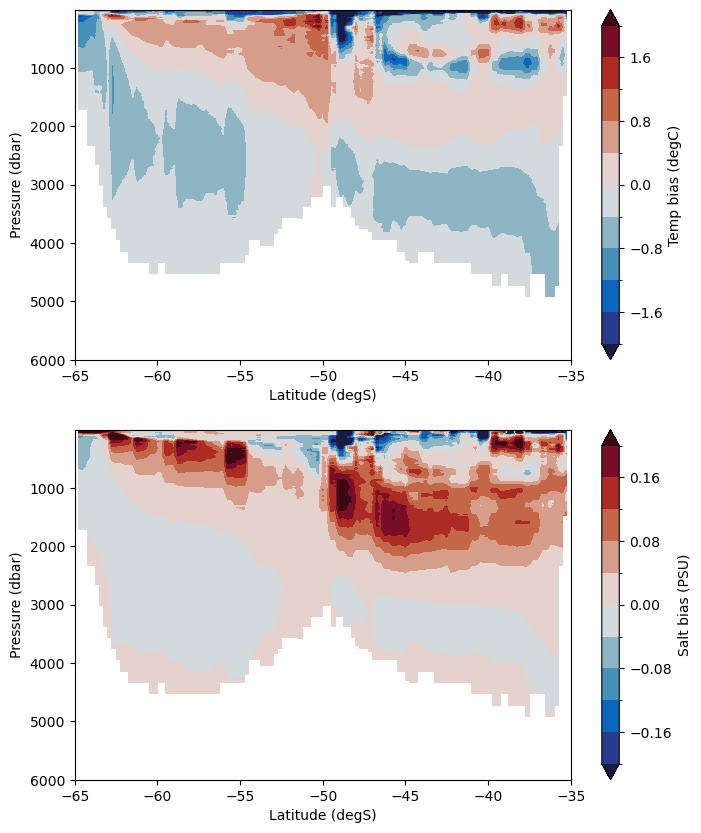

In [33]:
fig, axs = plt.subplots(2, 1, figsize = (8, 10))
(model_temperature_interp.mean('time') - temperature_interp).plot.contourf(ax = axs[0], vmin = -2, vmax = 2, levels = 11, cmap = cm.cm.balance,
                                 yincrease = False, cbar_kwargs = {'label':'Temp bias (degC)'})
(model_salinity_interp.mean('time') - salinity_interp).plot.contourf(ax = axs[1], vmin = -.2, vmax = .2, levels = 11, cmap = cm.cm.balance,
                                 yincrease = False, cbar_kwargs = {'label':'Salt bias (PSU)'})
for ax in axs:
    ax.set_xlabel('Latitude (degS)')
    ax.set_ylabel('Pressure (dbar)')
    ax.set_title('')

There's a salty bias in the model in the layers corresponding to NADW and AAIW. The dipole at 50S in the temperature biases is due to the ACC fronts shifted a bit in the model compared to obs - it is not that big of a deal.

We can look at the model's standard deviation, to see whether these biases fall within their magnitude, or if they're outside what we would call "intrinsic" variability in the model. Remember that we are comparing a time mean with a snapshot, the later being subject to high frequency variability that is averaged out when taking the time mean. 

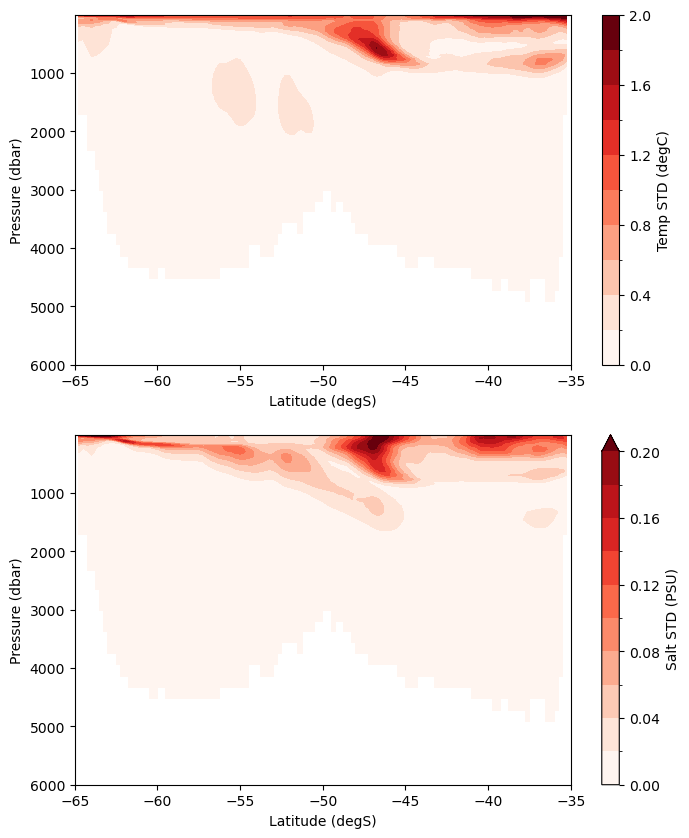

In [37]:
fig, axs = plt.subplots(2, 1, figsize = (8, 10))
model_temperature_interp.std('time').plot.contourf(ax = axs[0], vmin = 0, vmax = 2, levels = 11, cmap = 'Reds',
                                 yincrease = False, cbar_kwargs = {'label':'Temp STD (degC)'})
model_salinity_interp.std('time').plot.contourf(ax = axs[1], vmin = 0, vmax = .2, levels = 11, cmap = 'Reds',
                                 yincrease = False, cbar_kwargs = {'label':'Salt STD (PSU)'})
for ax in axs:
    ax.set_xlabel('Latitude (degS)')
    ax.set_ylabel('Pressure (dbar)')
    ax.set_title('')

The biases do exceed the standard deviation. This is not uncommon - models like this one are usually initialised from an "observed ocean state", but are freely evolving afterwards. As model time goes by, they tend to drift away from observations, and so biases increase with time. 

This means that looking at specific values of temperature and salinity in a water mass in a model is probably not useful/relevant. But what matters is the representation of processes - i.e. does the circulation intensify with stronger winds, do the bottom waters warm throughout time, etc. Is there a trend throughout the study period?

To calculate trends, we can use a python package developed by members of the COSIMA community, `xarrayMannKendall`.

In [38]:
import xarrayMannKendall as xrmk

In [56]:
MK_class = xrmk.Mann_Kendall_test(model_temperature, 
                                  'time',
                                  coords_name = {'time':'time', 'yt_ocean':'x', 'st_ocean':'y'})
temp_trends = MK_class.compute()

c:\Users\jmneme\AppData\Local\miniconda3\envs\ksa206\Lib\site-packages\xarrayMannKendall\decorators.py:38: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  self.DataArray = self.DataArray.rename(rename_dict)


In [57]:
temp_trends = temp_trends.rename({'x':'yt_ocean', 'y':'st_ocean'})
temp_trends = temp_trends.where(~np.isnan(model_temperature.isel(time = 0)))

In [58]:
MK_class = xrmk.Mann_Kendall_test(model_salinity, 
                                  'time',
                                  coords_name = {'time':'time', 'yt_ocean':'x', 'st_ocean':'y'})
salt_trends = MK_class.compute()

c:\Users\jmneme\AppData\Local\miniconda3\envs\ksa206\Lib\site-packages\xarrayMannKendall\decorators.py:38: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  self.DataArray = self.DataArray.rename(rename_dict)


In [59]:
salt_trends = salt_trends.rename({'x':'yt_ocean', 'y':'st_ocean'})
salt_trends = salt_trends.where(~np.isnan(model_salinity.isel(time = 0)))

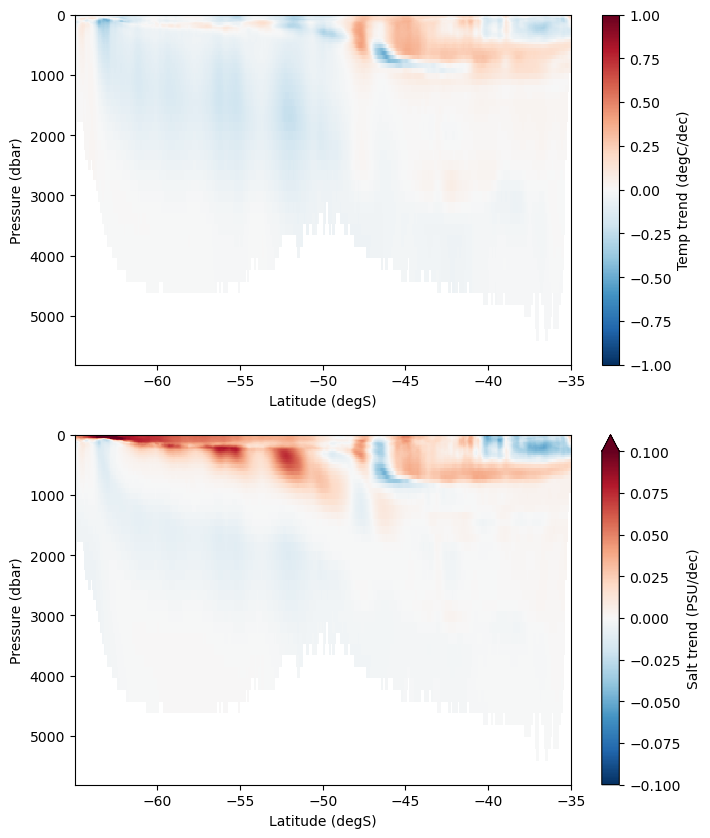

In [63]:
fig, axs = plt.subplots(2, 1, figsize = (8, 10))
(120*temp_trends['trend']).plot(ax = axs[0], vmin = -1, vmax = 1, cmap = 'RdBu_r',
                                 yincrease = False, cbar_kwargs = {'label':'Temp trend (degC/dec)'})
(120*salt_trends['trend']).plot(ax = axs[1], vmin = -.1, vmax = .1, cmap = 'RdBu_r',
                                 yincrease = False, cbar_kwargs = {'label':'Salt trend (PSU/dec)'})
for ax in axs:
    ax.set_xlabel('Latitude (degS)')
    ax.set_ylabel('Pressure (dbar)')
    ax.set_title('')